In [1]:
from typing import Union
import fkassim.FastKassim as fkassim
import ginza
from ginza import lemma_, bunsetu, sub_phrases
import spacy
from nltk import Tree
# fkassim.download() only run first time, or never since its for japanese

In [2]:
def bunsetsu_sub(token):
    """Performs substitution similar to Tolmachev et al."""
    result = []
    # bunsetsu_head_list = list(ginza.bunsetu_head_tokens(token.doc))
    bunsetsu_span = ginza.bunsetu_span(token)
    # return [t.lemma_ if t not in bunsetsu_head_list else t.pos_ for t in bunsetsu_span]
    # if token not in bunsetsu_head_list:
    #     return token.lemma_
    # else: return token.pos_
    for t in bunsetsu_span:
        # skip punctuation
        if t.is_punct:
            continue
        # if t  the head word of the bunsetsu, or if it depends on a right token from the same bunsetsu
        if ginza.is_bunsetu_head(t) or (ginza.head(t) == token and t in ginza.lefts(token)):
            result.append(t.pos_)
        else: result.append(t.lemma_)
    return "+".join(result)

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def build_nltk_tree_from_ginza_rec(token, bunsetsu_tokens, node_repr):
    # if empty, just print token
    #print(token, list(token.children))
    # to avoid repetitions, use only one bunsetsu once
    selected_children = intersection(token.children, bunsetsu_tokens)

    if not selected_children:
        return node_repr(token)
    
    # else recursively do it again
    # ordering problem, this way they are ordered
    children_trees = [build_nltk_tree_from_ginza_rec(child_token, bunsetsu_tokens, node_repr=node_repr)
                       for child_token in selected_children]
    return Tree(node_repr(token), children_trees)

def build_nltk_tree_from_ginza(sentence: Union[str,spacy.tokens.doc.Doc, spacy.tokens.span.Span], nlp=None,
                                node_repr:callable(spacy.tokens.token.Token)=bunsetsu_sub):
    """Given a string, parses it and returns a nltk Tree. It will then be used by the fastkassim method.
    Otherwise, a doc (span) that has already been sentencised can be passed. Otherwise it will be sentencised.
    Input:
    sentence: 
    nlp: Optional
    node_repr: the function to apply to each token (eg use the full bunsetsu or do substitutions)

    returns: nlkt.Tree object"""
    doc = sentence
    if type(sentence) is str:
        if nlp is None:
            raise ValueError(f"If string object you need to pass an nlp spacy object, not {nlp}")
        doc = nlp(sentence)
        doc = list(doc.sents)[0]
    elif type(sentence) is spacy.tokens.doc.Doc:
        doc = list(doc.sents)[0]
    
    root = doc.root
    spans = ginza.bunsetu_spans(doc)
    bunsetsu_tokens = [span.root for span in spans]
    return build_nltk_tree_from_ginza_rec(token=root, bunsetsu_tokens=bunsetsu_tokens, node_repr=node_repr)

In [3]:
nlp = spacy.load('ja_ginza_electra')
FastKassim = fkassim.FastKassim(fkassim.FastKassim.LTK)

/home/enrico_benedetti/anaconda3/envs/nlp_env/lib/python3.8/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'ja_ginza_electra' (5.1.3) was trained with spaCy v3.2.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
s0 = 'This is an english sentence.'
s1 = '田中さんはカレーを食べました。' # this should be similar to the second
s2 = '犬は水を飲んだ。' # this should be similar to the first
s3 = '見たことがないです。' # this should be not similar to anything
s4 = '可愛い田中さんはカレーを食べました。' 

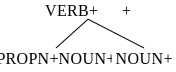

In [5]:
build_nltk_tree_from_ginza(s1, nlp=nlp, node_repr=bunsetsu_sub)

In [6]:
build_nltk_tree_from_ginza(s4, nlp=nlp, node_repr=bunsetsu_sub).pretty_print()

       VERB+ます+た             
   ________|__________        
  |              PROPN+NOUN+は
  |                   |       
NOUN+を               ADJ     



In [7]:
def fkassim_custom_tokenizer_spacy(sentence: str):
    l = []
    for t in nlp.tokenizer(sentence):
        l.append(t.text)
    return l

In [56]:
s1_parsed = build_nltk_tree_from_ginza('可愛い田中さんはカレーを食べました。', nlp=nlp)
s1_parsed.pretty_print()
s1_parsed = build_nltk_tree_from_ginza('カレーを可愛い田中さんは食べました。', nlp=nlp)
s1_parsed.pretty_print()

       VERB+ます+た             
   ________|__________        
  |              PROPN+NOUN+は
  |                   |       
NOUN+を               ADJ     

       VERB+ます+た             
   ________|__________        
  |              PROPN+NOUN+は
  |                   |       
NOUN+を               ADJ     



In [41]:
# see how it gets tokenized
# it wants a list of token string/text
eng_parsed = FastKassim.parse_document(s0)
# s1_parsed = FastKassim.parse_document(s1, tokenizer=fkassim_custom_tokenizer_spacy)
# s2_parsed = FastKassim.parse_document(s2, tokenizer=fkassim_custom_tokenizer_spacy)
# s3_parsed = FastKassim.parse_document(s3, tokenizer=fkassim_custom_tokenizer_spacy)
s1_parsed = build_nltk_tree_from_ginza(s1, nlp=nlp)
s2_parsed = build_nltk_tree_from_ginza(s2, nlp=nlp)
s3_parsed = build_nltk_tree_from_ginza(s3, nlp=nlp)
s4_parsed = build_nltk_tree_from_ginza(s4, nlp=nlp)

# second test
s1_parsed = nltk_spacy_tree(s1, nlp=nlp)
s2_parsed = nltk_spacy_tree(s2, nlp=nlp)
s3_parsed = nltk_spacy_tree(s3, nlp=nlp)
s4_parsed = nltk_spacy_tree(s4, nlp=nlp)
print(s1_parsed)
print(eng_parsed)

[Tree('VERB_ROOT', [Tree('NOUN_nsubj', ['PROPN_compound', 'ADP_case']), Tree('NOUN_obj', ['ADP_case']), 'AUX_aux', 'AUX_aux', 'PUNCT_punct'])]
[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('DT', ['This'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP', [Tree('DT', ['an']), Tree('JJ', ['english']), Tree('NN', ['sentence'])])]), Tree('.', ['.'])])])]


In [10]:
eng_parsed[0].pretty_print()

         ROOT                         
          |                            
          S                           
  ________|_________________________   
 |             VP                   | 
 |     ________|_____               |  
 NP   |              NP             | 
 |    |    __________|_______       |  
 DT  VBZ  DT         JJ      NN     . 
 |    |   |          |       |      |  
This  is  an      english sentence  . 



In [35]:
type(nlp('ciao')[0])

spacy.tokens.token.Token

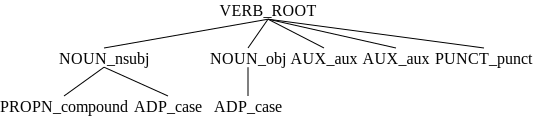

In [42]:
s1_parsed[0]

In [59]:

print(s1, s2, FastKassim.compute_similarity_preparsed(s1_parsed, s2_parsed))
print(s1, s3, FastKassim.compute_similarity_preparsed(s1_parsed, s3_parsed))
print(s2, s3, FastKassim.compute_similarity_preparsed(s2_parsed, s3_parsed))
print(s1, s4, FastKassim.compute_similarity_preparsed(s1_parsed, s4_parsed))

田中さんはカレーを食べました。 犬は水を飲んだ。 0.0
田中さんはカレーを食べました。 見たことがないです。 0.0
犬は水を飲んだ。 見たことがないです。 0.2279601015231132
田中さんはカレーを食べました。 可愛い田中さんはカレーを食べました。 0.0


In [48]:
s1_parsed[0].pretty_print()
s2_parsed[0].pretty_print()
s4_parsed[0].pretty_print()

                 VERB_ROOT                                             
    _________________|____________________________________________      
   |       |         |                     NOUN_nsubj          NOUN_obj
   |       |         |             ____________|_________         |     
AUX_aux AUX_aux PUNCT_punct PROPN_compound            ADP_case ADP_case

         VERB_ROOT                     
    _________|____________________      
   |         |      NOUN_nsubj NOUN_obj
   |         |          |         |     
AUX_aux PUNCT_punct  ADP_case  ADP_case

                            VERB_ROOT                                 
    ____________________________|________________________________      
   |       |         |                  NOUN_nsubj            NOUN_obj
   |       |         |           ___________|___________         |     
AUX_aux AUX_aux PUNCT_punct  ADJ_acl  PROPN_compound ADP_case ADP_case



In [12]:
# testing tree conversion

# Parse the sentence using SpaCy
doc = nlp('日本の四季は非常に美しく、春には桜の花が満開に咲き、夏には太陽が輝き、秋には紅葉が山々を彩り、冬には雪が積もり、その美しさに心が癒されます。')
doc = nlp('可愛い田中さんはカレーを食べました。')
# Method to convert SpaCy dependency tree to NLTK Tree format

In [ ]:
# root_token
# spans = ginza.bunsetu_spans(doc)
# bunsetsu_tokens = [span.root for span in spans]
# for token in bunsetsu_tokens:
#     print(ginza.bunsetu(token))
#     #print(token.children, bunsetsu_tokens)
#     print(intersection(token.children, bunsetsu_tokens))
#     #print(list(token.ancestors))

In [13]:

doc

可愛い田中さんはカレーを食べました。

In [14]:
# TREE norm tests

doc = list(doc.sents)[0]
root = doc.root
spans = ginza.bunsetu_spans(doc)
bunsetsu_tokens = [span.root for span in spans]
token = doc.root
#selected_children = intersection(token.children, bunsetsu_tokens)
#print(selected_children)
#if not selected_children:
#    print(bunsetsu_sub(token))
    
# else recursively do it again
# ordering problem, this way they are ordered
children_trees = Tree.fromlist(['sto', ['cazzo']])
tree = Tree(bunsetsu_sub(token), children_trees)

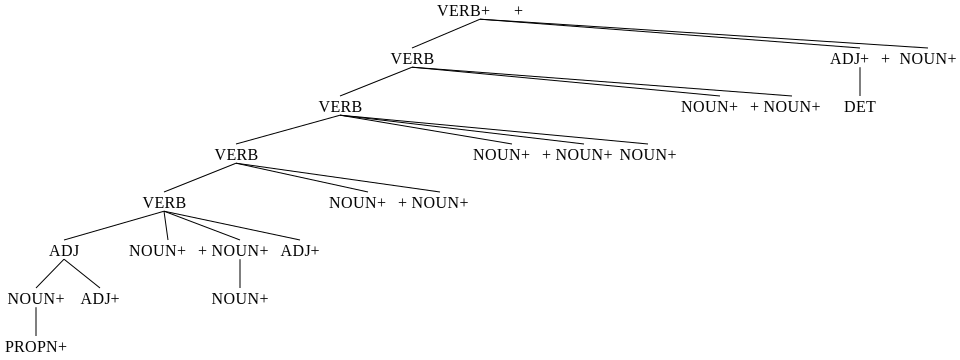

In [15]:
s_tree = '日本の四季は非常に美しく、春には桜の花が満開に咲き、夏には太陽が輝き、秋には紅葉が山々を彩り、冬には雪が積もり、その美しさに心が癒されます。'
tree = build_nltk_tree_from_ginza(s_tree, nlp=nlp, node_repr=bunsetsu_sub)
#tree.chomsky_normal_form()
tree

In [71]:
def bunsetsu_sub(token):
    """Performs substitution similar to Tolmachev et al."""
    result = []
    # bunsetsu_head_list = list(ginza.bunsetu_head_tokens(token.doc))
    bunsetsu_span = ginza.bunsetu_span(token)
    # return [t.lemma_ if t not in bunsetsu_head_list else t.pos_ for t in bunsetsu_span]
    # if token not in bunsetsu_head_list:
    #     return token.lemma_
    # else: return token.pos_
    for t in bunsetsu_span:
        # skip punctuation
        if t.is_punct:
            continue
        # if t  the head word of the bunsetsu, or if it depends on a right token from the same bunsetsu
        if ginza.is_bunsetu_head(t) or (ginza.head(t) == token and t in ginza.lefts(token)):
            result.append(t.pos_)
        else: result.append(t.lemma_)
    return "+".join(result)

def nltk_spacy_tree(sent, nlp):
    """
    Visualize the SpaCy dependency tree with nltk.tree
    """
    doc = nlp(sent)
    def token_format(token):
        return "_".join([token.pos_, token.dep_])

    def to_nltk_tree(node):
        if node.n_lefts + node.n_rights > 0:
            return Tree(token_format(node),
                       [to_nltk_tree(child) 
                        for child in node.children]
                   )
        else:
            return token_format(node)

    tree = [to_nltk_tree(sent.root) for sent in doc.sents]
    # The first item in the list is the full tree
    return tree[0]

In [73]:
doc = '田中さんはカレーを食べました。' 
   
tree1 = nltk_spacy_tree(doc, nlp)
tree1.pretty_print()

doc = 'カレーを田中さんは食べました。' 
   
tree2 = nltk_spacy_tree(doc, nlp)
tree2.pretty_print()

                 VERB_ROOT                                             
    _________________|____________________________________________      
   |       |         |                     NOUN_nsubj          NOUN_obj
   |       |         |             ____________|_________         |     
AUX_aux AUX_aux PUNCT_punct PROPN_compound            ADP_case ADP_case

                 VERB_ROOT                                             
    _________________|__________________________________                
   |       |         |      NOUN_obj                NOUN_nsubj         
   |       |         |         |            ____________|_________      
AUX_aux AUX_aux PUNCT_punct ADP_case PROPN_compound            ADP_case



In [77]:
tree1.label()

'VERB_ROOT'

In [68]:
print(tree1)
print(tree2)

[Tree('VERB_ROOT', [Tree('NOUN_nsubj', ['PROPN_compound', 'ADP_case']), Tree('NOUN_obj', ['ADP_case']), 'AUX_aux', 'AUX_aux', 'PUNCT_punct'])]
[Tree('VERB_ROOT', [Tree('NOUN_obj', ['ADP_case']), Tree('NOUN_nsubj', ['PROPN_compound', 'ADP_case']), 'AUX_aux', 'AUX_aux', 'PUNCT_punct'])]
